In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd


In [2]:
data_path = Path('data') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

/home/estela19/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data.groupby('UserId').count()

,ItemId,Rating,Time
UserId,,,
1,53,53,53
2,129,129,129
3,51,51,51
4,21,21,21
5,198,198,198
...,...,...,...
6036,888,888,888
6037,202,202,202
6038,20,20,20


In [4]:
data.groupby('UserId').max() - data.groupby('UserId').min()

,ItemId,Rating,Time
UserId,,,
1,3407,2,524332
2,3872,4,2050
3,3764,4,1486
4,3442,4,358
5,3793,4,5513
...,...,...,...
6036,3572,4,45847
6037,3526,4,92843
6038,3316,4,10377


In [5]:
data.groupby('UserId').max()

,ItemId,Rating,Time
UserId,,,
1,3408,5,978824351
2,3893,5,978300174
3,3868,5,978298504
4,3702,5,978294282
5,3799,5,978246585
...,...,...,...
6036,3576,5,956755196
6037,3543,5,956801840
6038,3548,5,956717204


In [6]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [7]:
session_length.min(), session_length.max()

(20, 2314)

In [8]:
session_length.quantile(0.999)

1343.181000000005

In [9]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [10]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

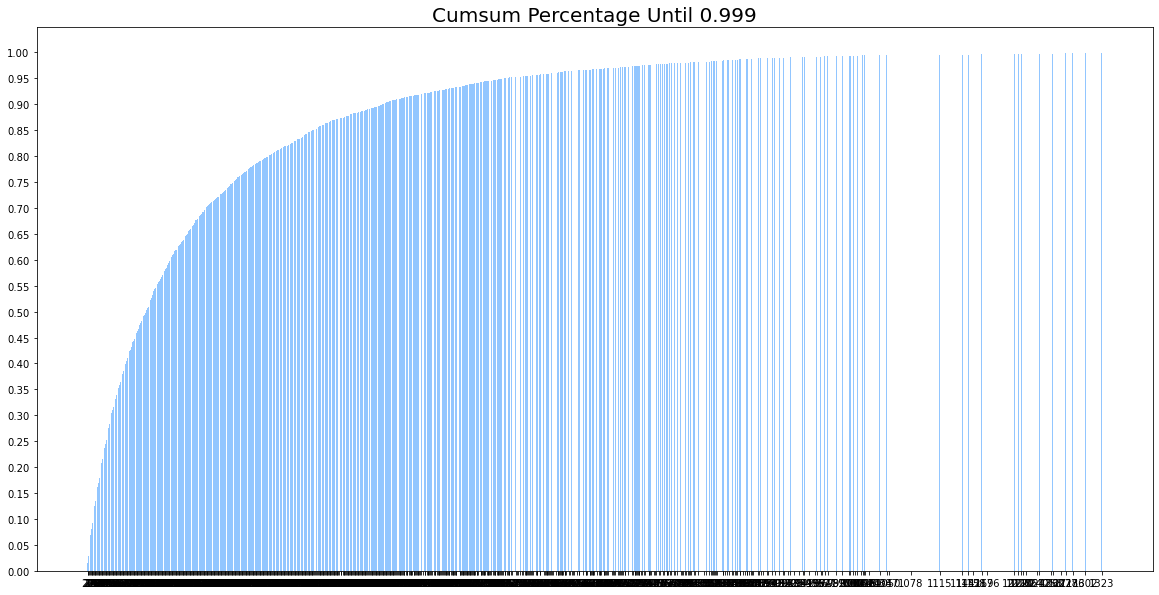

In [11]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-pastel')
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999)
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [12]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [13]:
print(dt.datetime.utcfromtimestamp(data['Time'].min()).strftime('%Y-%m-%d %H:%M:%S'))
print(dt.datetime.utcfromtimestamp(data['Time'].max()).strftime('%Y-%m-%d %H:%M:%S'))

2000-04-25 23:05:32
2003-02-28 17:49:50


In [14]:
print(len(data[data['Time'] > latest - (86400*365*3)]))  # 최근 3년 데이터 수
print(len(data[data['Time'] > latest - (86400*365*2)]))  # 최근 2년 데이터 수
print(len(data[data['Time'] > latest - (86400*365*1)]))  # 최근 1년 데이터 수

1000209
69349
21704


# Data cleansing

In [15]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [16]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


# Dataset split

In [17]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (86400*n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - (86400*n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [18]:
print(len(data[data['Time'] > latest - (86400*100)]))
print(len(data[data['Time'] > latest - (86400*200)]))

5067
10267


In [19]:
tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=100)

In [20]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [21]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 856543
	 Sessions: 5690
	 Items: 3416
	 First Time : 956703932
	 Last Time : 1029141407

* valid Set Stats Info
	 Events: 36149
	 Sessions: 96
	 Items: 2949
	 First Time : 956853488
	 Last Time : 1037810320

* test Set Stats Info
	 Events: 106919
	 Sessions: 254
	 Items: 3297
	 First Time : 957179713
	 Last Time : 1046454590



In [22]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

# Data Pipeline

In [23]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [24]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,978300019,0
22,1,1270,5,978300055,1
27,1,1721,4,978300055,2
37,1,1022,5,978300055,3
24,1,2340,3,978300103,4
36,1,1836,5,978300172,5
3,1,3408,4,978300275,6
7,1,2804,5,978300719,7
47,1,1207,4,978300719,8
0,1,1193,5,978300760,9


In [25]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 856079, 856202, 856543], dtype=int32)

In [26]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5687, 5688, 5689])

# DataLoader

In [27]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [28]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,978300019,0
22,1,1270,5,978300055,1
27,1,1721,4,978300055,2
37,1,1022,5,978300055,3
24,1,2340,3,978300103,4
36,1,1836,5,978300172,5
3,1,3408,4,978300275,6
7,1,2804,5,978300719,7
47,1,1207,4,978300719,8
0,1,1193,5,978300760,9


In [29]:
iter_ex = iter(tr_data_loader)

In [30]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


# Modeling

In [31]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## Model Architecture

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

2021-11-11 22:21:14.463553: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [33]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [34]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)

In [35]:
model = create_model(args)

2021-11-11 22:21:18.759335: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-11 22:21:19.019850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-11 22:21:19.019998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 68 deviceMemorySize: 10.00GiB deviceMemoryBandwidth: 707.88GiB/s
2021-11-11 22:21:19.020040: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-11-11 22:21:19.033360: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-11-11 22:21:19.033442: I tensorflow/stream_executo

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      520200    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


## Training

In [36]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

### First Try
data_loader batch 4  
training batch 32  
epoch 10 (조기종료)

In [37]:
train_model(model, args)

Train:   0%|          | 0/13294 [00:00<?, ?it/s]2021-11-11 22:21:52.471605: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-11 22:21:52.476373: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699995000 Hz
2021-11-11 22:21:52.595937: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-11-11 22:21:53.924531: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-11-11 22:21:54.217281: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-11-11 22:21:55.505332: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-11-11 22:21:55.505534: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. Thi

	 - Recall@20 epoch 1: 0.264955
	 - MRR@20    epoch 1: 0.068888



Evaluation:  50%|████▉     | 280/563 [00:44<00:44,  6.31it/s]


	 - Recall@20 epoch 2: 0.312221
	 - MRR@20    epoch 2: 0.087191



Evaluation:  50%|████▉     | 280/563 [00:43<00:43,  6.51it/s]


	 - Recall@20 epoch 3: 0.325056
	 - MRR@20    epoch 3: 0.095172



Evaluation:  50%|████▉     | 280/563 [00:44<00:45,  6.26it/s]


	 - Recall@20 epoch 4: 0.332366
	 - MRR@20    epoch 4: 0.099437



Evaluation:  50%|████▉     | 280/563 [00:42<00:42,  6.60it/s]


	 - Recall@20 epoch 5: 0.334431
	 - MRR@20    epoch 5: 0.100938



Evaluation:  50%|████▉     | 280/563 [00:44<00:45,  6.29it/s]


	 - Recall@20 epoch 6: 0.335714
	 - MRR@20    epoch 6: 0.102098



Evaluation:  50%|████▉     | 280/563 [00:43<00:43,  6.46it/s]


	 - Recall@20 epoch 7: 0.338058
	 - MRR@20    epoch 7: 0.102853



Evaluation:  50%|████▉     | 280/563 [00:41<00:42,  6.69it/s]


	 - Recall@20 epoch 8: 0.338560
	 - MRR@20    epoch 8: 0.103088



Evaluation:  50%|████▉     | 280/563 [00:44<00:44,  6.30it/s]


	 - Recall@20 epoch 9: 0.338504
	 - MRR@20    epoch 9: 0.102573



Evaluation:  50%|████▉     | 280/563 [00:44<00:45,  6.28it/s]


	 - Recall@20 epoch 10: 0.340402
	 - MRR@20    epoch 10: 0.103302



Evaluation:  50%|████▉     | 280/563 [00:43<00:44,  6.38it/s]


	 - Recall@20 epoch 11: 0.340067
	 - MRR@20    epoch 11: 0.103755



Train:  34%|███▍      | 4518/13294 [01:09<02:15, 64.97it/s, accuracy=0.0625, train_loss=5.21]


KeyboardInterrupt: 

In [38]:
# Inference
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  82%|████████▏ | 1360/1666 [03:37<00:48,  6.27it/s]

	 - Recall@20: 0.276919
	 - MRR@20: 0.084620



### Second Try  
data_loader batch 32  
training batch 32  
epoch 20

In [205]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

[   0    1    2 ... 5687 5688 5689]


Train:   0%|          | 0/26589 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [05:34<00:02, 78.91it/s, accuracy=0, train_loss=5.38]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:19<00:24, 10.85it/s]


	 - Recall@20 epoch 1: 0.254340
	 - MRR@20    epoch 1: 0.067836



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0, train_loss=7.85]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [06:09<00:02, 71.59it/s, accuracy=0.0625, train_loss=5.05]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:20<00:24, 10.79it/s]


	 - Recall@20 epoch 2: 0.288158
	 - MRR@20    epoch 2: 0.082659



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0.0312, train_loss=7.05]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [06:33<00:02, 67.09it/s, accuracy=0.0312, train_loss=4.79]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:17<00:23, 11.11it/s]


	 - Recall@20 epoch 3: 0.299588
	 - MRR@20    epoch 3: 0.087901



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0.0312, train_loss=7.62]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [05:55<00:02, 74.41it/s, accuracy=0, train_loss=4.81]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:15<00:22, 11.49it/s]


	 - Recall@20 epoch 4: 0.306496
	 - MRR@20    epoch 4: 0.090739



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0, train_loss=7.44]    

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [05:01<00:01, 87.67it/s, accuracy=0, train_loss=4.71]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:13<00:22, 11.77it/s]


	 - Recall@20 epoch 5: 0.305736
	 - MRR@20    epoch 5: 0.091429



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.87]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [05:21<00:02, 82.30it/s, accuracy=0.0312, train_loss=4.77]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:14<00:22, 11.54it/s]


	 - Recall@20 epoch 6: 0.304398
	 - MRR@20    epoch 6: 0.092328



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0, train_loss=6.99]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [05:33<00:02, 79.15it/s, accuracy=0.0312, train_loss=4.54]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:14<00:22, 11.55it/s]


	 - Recall@20 epoch 7: 0.303892
	 - MRR@20    epoch 7: 0.092910



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.64]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [05:28<00:02, 80.39it/s, accuracy=0, train_loss=4.6]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:13<00:22, 11.75it/s]


	 - Recall@20 epoch 8: 0.304073
	 - MRR@20    epoch 8: 0.092483



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.53]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [05:33<00:02, 79.35it/s, accuracy=0, train_loss=4.71]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:16<00:23, 11.27it/s]


	 - Recall@20 epoch 9: 0.304832
	 - MRR@20    epoch 9: 0.092293



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.23]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [06:12<00:02, 70.93it/s, accuracy=0.0625, train_loss=4.76]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:18<00:23, 10.97it/s]


	 - Recall@20 epoch 10: 0.304579
	 - MRR@20    epoch 10: 0.092835



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0, train_loss=7.64]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [06:32<00:02, 67.29it/s, accuracy=0.0625, train_loss=4.68]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:22<00:25, 10.43it/s]


	 - Recall@20 epoch 11: 0.303458
	 - MRR@20    epoch 11: 0.091995



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.5] 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [05:46<00:02, 76.36it/s, accuracy=0.0625, train_loss=4.73]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:14<00:22, 11.59it/s]


	 - Recall@20 epoch 12: 0.303422
	 - MRR@20    epoch 12: 0.092268



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0, train_loss=7.72]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [05:51<00:02, 75.26it/s, accuracy=0.0625, train_loss=4.7]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:15<00:22, 11.44it/s]


	 - Recall@20 epoch 13: 0.303168
	 - MRR@20    epoch 13: 0.092081



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.35] 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [06:01<00:02, 73.15it/s, accuracy=0.0625, train_loss=4.61]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:15<00:22, 11.44it/s]


	 - Recall@20 epoch 14: 0.302047
	 - MRR@20    epoch 14: 0.091783



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0, train_loss=6.81]     

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [05:53<00:02, 74.81it/s, accuracy=0, train_loss=4.75]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:15<00:22, 11.47it/s]


	 - Recall@20 epoch 15: 0.302192
	 - MRR@20    epoch 15: 0.092064



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.68]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [05:56<00:02, 74.15it/s, accuracy=0.0312, train_loss=4.66]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:14<00:22, 11.53it/s]


	 - Recall@20 epoch 16: 0.298720
	 - MRR@20    epoch 16: 0.091241



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0, train_loss=7.02]     

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [06:01<00:02, 73.18it/s, accuracy=0.0312, train_loss=4.69]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:15<00:22, 11.41it/s]


	 - Recall@20 epoch 17: 0.299479
	 - MRR@20    epoch 17: 0.090834



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.75]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [05:52<00:02, 74.97it/s, accuracy=0.0625, train_loss=4.61]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:14<00:22, 11.54it/s]


	 - Recall@20 epoch 18: 0.299262
	 - MRR@20    epoch 18: 0.090918



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0, train_loss=7.54]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [05:46<00:02, 76.24it/s, accuracy=0.0625, train_loss=4.66]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:15<00:22, 11.45it/s]


	 - Recall@20 epoch 19: 0.299334
	 - MRR@20    epoch 19: 0.090753



Train:   0%|          | 0/26589 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.72]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Train:  99%|█████████▉| 26423/26589 [05:47<00:02, 76.08it/s, accuracy=0, train_loss=4.79]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


Evaluation:   0%|          | 0/1126 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  77%|███████▋  | 864/1126 [01:15<00:22, 11.44it/s]

	 - Recall@20 epoch 20: 0.298503
	 - MRR@20    epoch 20: 0.090809



In [206]:
# Inference
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

Evaluation:   0%|          | 0/3333 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Evaluation:  91%|█████████ | 3024/3333 [04:27<00:27, 11.32it/s]

	 - Recall@20: 0.250816
	 - MRR@20: 0.074127

